Average Polarity for Positive Comments: 0.19375026016013788
Average Polarity for Negative Comments: 0.012643524175639971


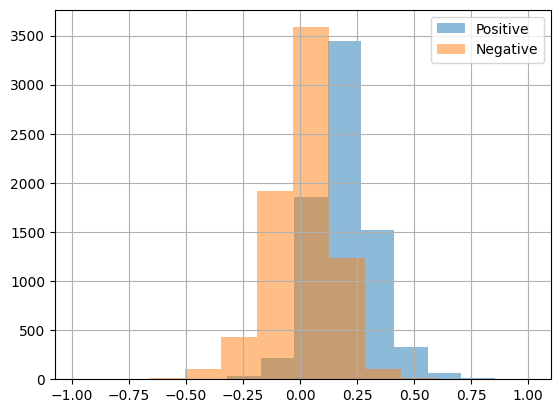

In [ ]:
#1- Preprocessing Steps
import pandas as pd
import nltk
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import string

# Load the CSV dataset
dataset = pd.read_csv('IMDB_Dataset.csv')

# Task 1-1: Change the label of positive data to 1 and negative data to 0
dataset['sentiment'] = dataset['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Task 1-2: Check for duplicate rows and delete them
dataset = dataset.drop_duplicates()

# Task 1-3: Randomly select 30% of the data set and delete the rest
dataset = dataset.sample(frac=0.3, random_state=42)

# Task 1-4: Obtain the polarity using TextBlob
dataset['polarity'] = dataset['review'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Task 1-5: Separate polarity of positive and negative comments, draw histogram, and get average polarity
positive_polarity = dataset[dataset['sentiment'] == 1]['polarity']
negative_polarity = dataset[dataset['sentiment'] == 0]['polarity']

# Draw histograms
positive_polarity.hist(label='Positive', alpha=0.5)
negative_polarity.hist(label='Negative', alpha=0.5)
plt.legend()

# Get average polarity
avg_positive_polarity = positive_polarity.mean()
avg_negative_polarity = negative_polarity.mean()

# Analyze results
print(f'Average Polarity for Positive Comments: {avg_positive_polarity}')
print(f'Average Polarity for Negative Comments: {avg_negative_polarity}')

# Task 1-6: Apply pre-processing steps
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])

    # Remove stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Apply preprocessing to the 'review' column
dataset['review'] = dataset['review'].apply(preprocess)

# Task 1-7: Divide the dataset into two equal parts for training and testing
train_data, test_data = train_test_split(dataset, test_size=0.5, random_state=42)

In [ ]:
#2- Clustering

# Task 2-1: Obtain the vector corresponding to each comment using the Bag of Words (BOW) method
from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the training data
X_train_bow = vectorizer.fit_transform(train_data['review'])

# Transform the test data
X_test_bow = vectorizer.transform(test_data['review'])

In [ ]:
# Task 2-2: Using the vector obtained for each sentence and using the K-means algorithm, divide the set of training and test sentences
from sklearn.cluster import KMeans

# Define the number of clusters
num_clusters = 3

# Apply K-means to the training data
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
train_data['cluster'] = kmeans.fit_predict(X_train_bow)

# Apply K-means to the test data
test_data['cluster'] = kmeans.predict(X_test_bow)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


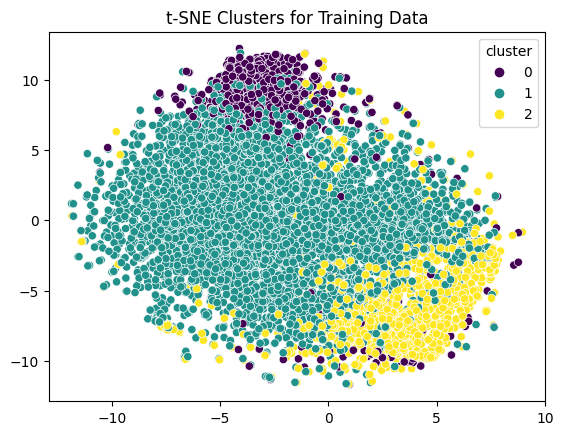

In [ ]:
# Task 2-3: Draw the obtained clusters using t-SNE
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# Apply t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform t-SNE on the training data
train_tsne = tsne.fit_transform(X_train_bow.toarray())

# Plot the t-SNE clusters
sns.scatterplot(x=train_tsne[:, 0], y=train_tsne[:, 1], hue=train_data['cluster'], palette='viridis')
plt.title('t-SNE Clusters for Training Data')
plt.show()

In [ ]:
# Task 2-4: To reduce the amount of data, select sentences from each cluster uniformly and calculate mi for each cluster
# Function to calculate mi for each cluster
def calculate_mi(cluster_data):
    # Calculate mi using the given formula
    mi = len(cluster_data) / len(train_data)
    return mi

# Calculate mi for each cluster
cluster_mis = train_data.groupby('cluster').apply(calculate_mi)

# Display mi for each cluster
for cluster, mi_value in cluster_mis.items():
    print(f'Mutual Information (mi) for Cluster {cluster}: {mi_value}')

Mutual Information (mi) for Cluster 0: 0.09251042086862983
Mutual Information (mi) for Cluster 1: 0.7497646900631976
Mutual Information (mi) for Cluster 2: 0.15772488906817264


In [ ]:
#3- Text vectorization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Task 3-1: Assign a unique number to each unique word using tf.keras.preprocessing.text.Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset['review'])

# Convert text sequences into numerical representations
X_train_sequences = tokenizer.texts_to_sequences(train_data['review'])
X_test_sequences = tokenizer.texts_to_sequences(test_data['review'])

# Task 3-2: Apply pad_sequences method to ensure data has the same dimension for processing
max_sequence_length = 100

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')


In [ ]:
#4- Word Embedding
import urllib.request
import zipfile
import os
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer

# Download word vectors
fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip', 'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    os.remove('wiki-news-300d-1M.vec.zip')
    print('Download and extraction done.')

# Create a tokenizer and fit on dataset
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset['review'])

# Create an embedding matrix
word_index = tokenizer.word_index
embedding_dim = 300  # Dimension of the word vectors

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

with open(fname, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        if word in word_index:
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_matrix[word_index[word]] = coefs

# Embedding_matrix contains the embeddings for words in tokenizer's vocabulary.


Epoch 1/10
233/233 [==============================] - 68s 279ms/step - loss: 0.6843 - accuracy: 0.5337 - val_loss: 0.7206 - val_accuracy: 0.7185
Epoch 2/10
233/233 [==============================] - 59s 252ms/step - loss: 0.6138 - accuracy: 0.7019 - val_loss: 0.5195 - val_accuracy: 0.7661
Epoch 3/10
233/233 [==============================] - 58s 248ms/step - loss: 0.5022 - accuracy: 0.7858 - val_loss: 0.4483 - val_accuracy: 0.8118
Epoch 4/10
233/233 [==============================] - 74s 319ms/step - loss: 0.5440 - accuracy: 0.7296 - val_loss: 0.6718 - val_accuracy: 0.5718
Epoch 5/10
233/233 [==============================] - 64s 277ms/step - loss: 0.5147 - accuracy: 0.7515 - val_loss: 0.4475 - val_accuracy: 0.8131
Epoch 6/10
233/233 [==============================] - 61s 264ms/step - loss: 0.4187 - accuracy: 0.8197 - val_loss: 0.3918 - val_accuracy: 0.8336
Epoch 7/10
233/233 [==============================] - 63s 269ms/step - loss: 0.3788 - accuracy: 0.8385 - val_loss: 0.3694 - val_ac

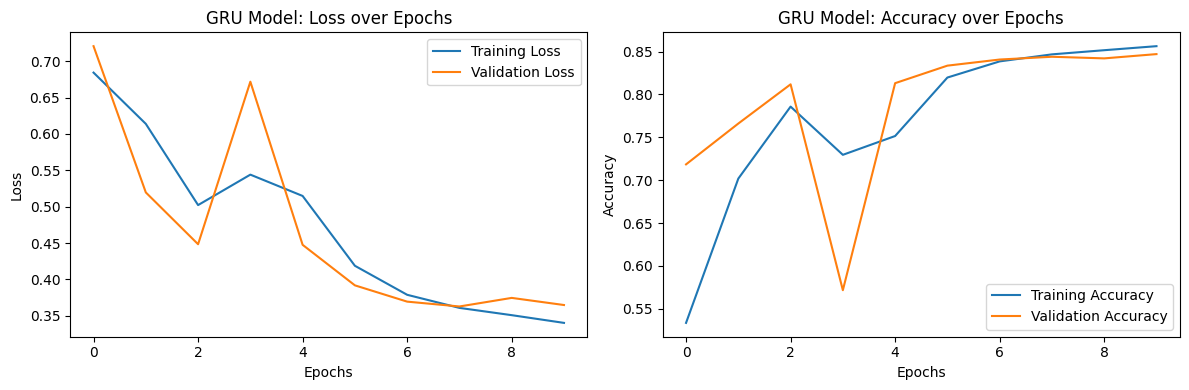

In [ ]:
#5- Making a bundle model

#Task 5-1: Build and Train a GRU Model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense


# Build and train GRU model
model_gru = Sequential()
model_gru.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model_gru.add(GRU(units=64, dropout=0.2, recurrent_dropout=0.2))
model_gru.add(Dense(units=1, activation='sigmoid'))

model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history_gru = model_gru.fit(
    X_train_padded,  # Use X_train_padded as training data
    train_data['sentiment'],  # Use labels (sentiment column) as training labels
    epochs=10,
    batch_size=32,
    validation_data=(X_test_padded, test_data['sentiment'])  # Use X_test_padded and test_data['sentiment'] for validation data
)

# Task 5-2: Plot Loss and Accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('GRU Model: Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_gru.history['accuracy'], label='Training Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Validation Accuracy')
plt.title('GRU Model: Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/10
233/233 [==============================] - 131s 535ms/step - loss: 0.5722 - accuracy: 0.6934 - val_loss: 0.4816 - val_accuracy: 0.7716
Epoch 2/10
233/233 [==============================] - 123s 527ms/step - loss: 0.4337 - accuracy: 0.8091 - val_loss: 0.3890 - val_accuracy: 0.8319
Epoch 3/10
233/233 [==============================] - 121s 519ms/step - loss: 0.3837 - accuracy: 0.8296 - val_loss: 0.3680 - val_accuracy: 0.8434
Epoch 4/10
233/233 [==============================] - 128s 550ms/step - loss: 0.3571 - accuracy: 0.8462 - val_loss: 0.3676 - val_accuracy: 0.8458
Epoch 5/10
233/233 [==============================] - 126s 543ms/step - loss: 0.3372 - accuracy: 0.8546 - val_loss: 0.3615 - val_accuracy: 0.8446
Epoch 6/10
233/233 [==============================] - 123s 527ms/step - loss: 0.3103 - accuracy: 0.8702 - val_loss: 0.3917 - val_accuracy: 0.8399
Epoch 7/10
233/233 [==============================] - 122s 523ms/step - loss: 0.2939 - accuracy: 0.8814 - val_loss: 0.3703 -

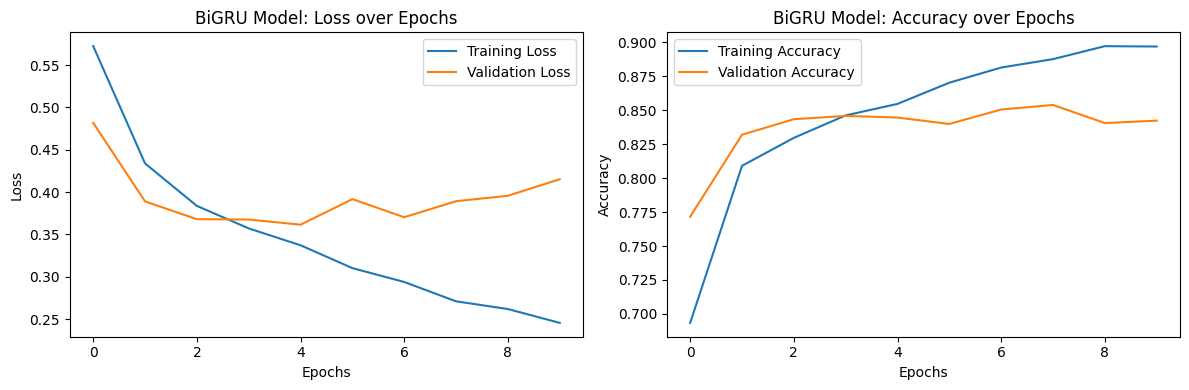

In [ ]:
#Task 5-3: Build a BiGRU Model with Keras
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense

# Build BiGRU model
model_bigru = Sequential()
model_bigru.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model_bigru.add(Bidirectional(GRU(units=64, dropout=0.2, recurrent_dropout=0.2)))
model_bigru.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model_bigru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Task 5-4: Train the BiGRU Model and Display Training Metrics
# Train BiGRU model
history_bigru = model_bigru.fit(
    X_train_padded,  # Use X_train_padded as training data
    train_data['sentiment'],  # Use labels (sentiment column) as training labels
    epochs=10,
    batch_size=32,
    validation_data=(X_test_padded, test_data['sentiment'])  # Use X_test_padded and test_data['sentiment'] for validation data
)

# Display the graphs of loss and accuracy
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history_bigru.history['loss'], label='Training Loss')
plt.plot(history_bigru.history['val_loss'], label='Validation Loss')
plt.title('BiGRU Model: Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_bigru.history['accuracy'], label='Training Accuracy')
plt.plot(history_bigru.history['val_accuracy'], label='Validation Accuracy')
plt.title('BiGRU Model: Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
